In [0]:
#Required Packages

import dlib
import cv2
from imutils import face_utils
from scipy.spatial import distance 
import math
import pandas as pd
import numpy as np

from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import warnings
from sklearn import preprocessing

p = "shape_predictor_68_face_landmarks.dat"
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(p)

In [0]:
#Feature Functions

def eye_aspect_ratio(eye):
	A = distance.euclidean(eye[1], eye[5])
	B = distance.euclidean(eye[2], eye[4])
	C = distance.euclidean(eye[0], eye[3])
	ear = (A + B) / (2.0 * C)
	return ear

def mouth_aspect_ratio(mouth):
    A = distance.euclidean(mouth[14], mouth[18])
    C = distance.euclidean(mouth[12], mouth[16])
    mar = (A ) / (C)
    return mar

def circularity(eye):
    A = distance.euclidean(eye[1], eye[4])
    radius  = A/2.0
    Area = math.pi * (radius ** 2)
    p = 0
    p += distance.euclidean(eye[0], eye[1])
    p += distance.euclidean(eye[1], eye[2])
    p += distance.euclidean(eye[2], eye[3])
    p += distance.euclidean(eye[3], eye[4])
    p += distance.euclidean(eye[4], eye[5])
    p += distance.euclidean(eye[5], eye[0])
    return 4 * math.pi * Area /(p**2)

def mouth_over_eye(eye):
    ear = eye_aspect_ratio(eye)
    mar = mouth_aspect_ratio(eye)
    mouth_eye = mar/ear
    return mouth_eye


def average(y_pred):
    for i in range(len(y_pred)):
        if i % 240 == 0 or (i+1) % 240 == 0:
            pass
        else: 
            average = float(y_pred[i-1] +  y_pred[i] + y_pred[i+1])/3
            if average >= 0.5:
                y_pred[i] = 1
            else:
                y_pred[i] = 0
    return y_pred

In [0]:
#Read in the Data file to Train Model
import pandas as pd
df = pd.read_csv('totalwithmaininfo.csv',sep=',')
df = df.drop(df.columns[0],axis=1)

train_percentage = 17/22
train_index = int(len(df)*train_percentage)
test_index = len(df)-train_index

df_train = df[:train_index]
df_test = df[-test_index:]

X_test = df_test.drop(["Y"],axis=1)
y_test = df_test["Y"]

X_train = df_train.drop('Y',axis=1)
y_train = df_train['Y']

In [0]:
#KNN

acc3_list = []
f1_score3_list = []
roc_3_list = []
from sklearn.neighbors import KNeighborsClassifier
for i in range(1,30):
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(X_train, y_train) 
    pred_KN = neigh.predict(X_test)
    pred_KN = average(pred_KN)
    y_score_3 = neigh.predict_proba(X_test)[:,1]
    acc3_list.append(accuracy_score(y_test, pred_KN))
    f1_score3_list.append(metrics.f1_score(y_test, pred_KN))
    roc_3_list.append(metrics.roc_auc_score(y_test, y_score_3))
    
    
neigh = KNeighborsClassifier(n_neighbors=acc3_list.index(max(acc3_list))+1)
neigh.fit(X_train, y_train) 
pred_KN = neigh.predict(X_test)
pred_KN = average(pred_KN)
y_score_3 = neigh.predict_proba(X_test)[:,1]
acc3 = accuracy_score(y_test, pred_KN)
f1_score_3 = metrics.f1_score(y_test, pred_KN)
roc_3 = metrics.roc_auc_score(y_test, y_score_3)
print([acc3,f1_score_3,roc_3])
print(confusion_matrix(y_test, pred_KN))

[0.7720833333333333, 0.7554760840411264, 0.7828010416666668]
[[1008  192]
 [ 355  845]]


In [0]:
def model(landmarks):

    features = pd.DataFrame(columns=["EAR","MAR","Circularity","MOE"])

    eye = landmarks[36:68]
    ear = eye_aspect_ratio(eye)
    mar = mouth_aspect_ratio(eye)
    cir = circularity(eye)
    mouth_eye = mouth_over_eye(eye)

    df = features.append({"EAR":ear,"MAR": mar,"Circularity": cir,"MOE": mouth_eye},ignore_index=True)

    df["EAR_N"] = (df["EAR"]-mean["EAR"])/ std["EAR"]
    df["MAR_N"] = (df["MAR"]-mean["MAR"])/ std["MAR"]
    df["Circularity_N"] = (df["Circularity"]-mean["Circularity"])/ std["Circularity"]
    df["MOE_N"] = (df["MOE"]-mean["MOE"])/ std["MOE"]
    
    Result = neigh.predict(df)
    if Result == 1:
        Result_String = "Drowsy"
    else:
        Result_String = "Alert"
    

    return Result_String, df.values

In [0]:
def calibration():
    data = []
    cap = cv2.VideoCapture(0)

    while True:
        # Getting out image by webcam 
        _, image = cap.read()
        # Converting the image to gray scale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Get faces into webcam's image
        rects = detector(image, 0)

        # For each detected face, find the landmark.
        for (i, rect) in enumerate(rects):
            # Make the prediction and transfom it to numpy array
            shape = predictor(gray, rect)
            shape = face_utils.shape_to_np(shape)
            data.append(shape)
            cv2.putText(image,"Calibrating...", bottomLeftCornerOfText, font, fontScale, fontColor,lineType)

            # Draw on our image, all the finded cordinate points (x,y) 
            for (x, y) in shape:
                cv2.circle(image, (x, y), 2, (0, 255, 0), -1)

        # Show the image
        cv2.imshow("Output", image)

        k = cv2.waitKey(5) & 0xFF
        if k == 27:
            break

    cv2.destroyAllWindows()
    cap.release()
    
    
    features_test = []
    for d in data:
        eye = d[36:68]
        ear = eye_aspect_ratio(eye)
        mar = mouth_aspect_ratio(eye)
        cir = circularity(eye)
        mouth_eye = mouth_over_eye(eye)
        features_test.append([ear, mar, cir, mouth_eye])
    
    features_test = np.array(features_test)
    x = features_test
    y = pd.DataFrame(x,columns=["EAR","MAR","Circularity","MOE"])
    df_means = y.mean(axis=0)
    df_std = y.std(axis=0)
    
    return df_means,df_std

font                   = cv2.FONT_HERSHEY_SIMPLEX
bottomLeftCornerOfText = (10,400)
fontScale              = 1
fontColor              = (255,255,255)
lineType               = 2

In [0]:
def live():
    cap = cv2.VideoCapture(0)
    data = []
    result = []
    while True:
        # Getting out image by webcam 
        _, image = cap.read()
        # Converting the image to gray scale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Get faces into webcam's image
        rects = detector(image, 0)

        # For each detected face, find the landmark.
        for (i, rect) in enumerate(rects):
            # Make the prediction and transfom it to numpy array
            shape = predictor(gray, rect)
            shape = face_utils.shape_to_np(shape)
            Result_String, features = model(shape)
            cv2.putText(image,Result_String, bottomLeftCornerOfText, font, fontScale, fontColor,lineType)
            data.append (features)
            result.append(Result_String)

            # Draw on our image, all the finded cordinate points (x,y) 
            for (x, y) in shape:
                cv2.circle(image, (x, y), 2, (0, 255, 0), -1)

        # Show the image
        cv2.imshow("Output", image)

        k = cv2.waitKey(300) & 0xFF
        if k == 27:
            break

    cv2.destroyAllWindows()
    cap.release()
    
    return data,result

font                   = cv2.FONT_HERSHEY_SIMPLEX
bottomLeftCornerOfText = (10,400)
fontScale              = 1
fontColor              = (255,255,255)
lineType               = 2

In [0]:
#Run Calibration
mean, std = calibration()

In [0]:
#Run Demonstration
features, result = live()

Text(0.5, 0, 'Time (Frames Captured)')

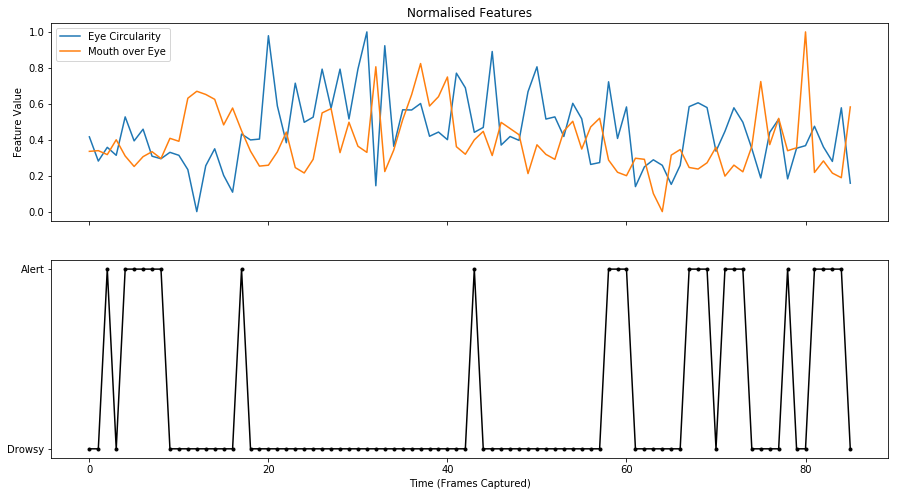

In [0]:
#Plot Results
features =np.vstack(features)
y = pd.DataFrame(features,columns=["EAR","MAR","Circularity","MOE","EAR_N","MAR_N","Circularity_N","MOE_N"])
y = y.drop(columns=["EAR_N","MAR_N","Circularity_N","MOE_N"])

x = y.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
y = pd.DataFrame(x_scaled,columns=["Eye Aspect Ratio","Mouth Aspect Ratio","Eye Circularity","Mouth over Eye"])


y ["Result"] = result


fig, (ax1, ax2) = plt.subplots(nrows=2,
                                ncols=1,
                                sharex=True,
                                sharey=False,
                                figsize=(15, 8))

ax1.set_title("Normalised Features")
#ax1.plot(y["Eye Aspect Ratio"])
#ax1.plot(y["Mouth Aspect Ratio"])
ax1.plot(y["Eye Circularity"])
ax1.plot(y["Mouth over Eye"])
ax1.legend(loc="best")
ax1.set_ylabel('Feature Value')


ax2.plot(y["Result"],marker = '.', color = "Black")
ax2.set_xlabel('Time (Frames Captured)')